# Portfolio Backtesting

In [1]:
import yfinance as yf 
import pandas as pd
from matplotlib import pylab as plt
import numpy as np
from datetime import datetime

from time import sleep

import quandl

import seaborn as sns

import sys
from scipy.stats import norm
import ezodf
import scipy.optimize as sco
import scipy

from sklearn.covariance import LedoitWolf

## Functions

### OPTIMAZATION

In [315]:
def Optimize_Portfolio(data ,risk_free = 0, objective = 'Kelly'):
    
    
    ret = (data+1).prod()**(1/len(data)) - 1 #cagr
    cov = data.cov().to_numpy()
    #cov_fit = LedoitWolf().fit(data)
    #cov = cov_fit.covariance_
    
    
    #need smaller step size
    num_assets = ret.shape[0]
    args = (ret, cov,risk_free)
    constraints = ({'type':'ineq', 'fun': lambda x: x},#all elements greater than one
                  #{'type':'ineq', 'fun': lambda x: 1 - np.sum(x)} # sum <= 1
                  {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})  
    
    if objective == 'Kelly':
        
        result = sco.minimize(kelly_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints) 
        
    elif objective == 'Sharpe':
        result = sco.minimize(sharpe_objective, num_assets*[1./num_assets,], args=args, 
                              method='SLSQP', constraints=constraints)
        
    
    return (result)

def kelly_objective(weights,ret, cov, risk_free = 0):
    
    kelly_ret = port_ret(weights, ret)
    obj = -(kelly_ret)
    
    return(obj)

def sharpe_objective(weights,ret, cov, risk_free = 0):
    ret = port_ret(weights, ret)
    std = port_var(weights, cov)**(1/2)
    
    obj = - (ret/std)
    return(obj)


def port_var(weights, cov):
    var = weights.dot(cov).dot(weights)
    return(var)

def port_ret(weights, ret, risk_free = 0):
    #needs to be array
    ret = ret - risk_free
    port_ret = weights.dot(ret)
    return(port_ret)

def risk_parity(data):
    vol = np.log((data)).std()

    sum_vol = 0
    for i in range(len(vol)):
        sum_vol =sum_vol + (1/vol[i])
    
    weight = []
    for i in range(len(vol)):
        w = (1/vol[i])/(sum_vol)
        weight.append(w)
   
    weight = [round(num, 2) for num in weight]
    return(weight)

### Help Function

In [3]:
def port_eval(port, lookback_period, freq = 'D'):
    
    port = pd.DataFrame(port)
    port_ret = calc_port_ret(port)
    
    Roll_Max = port.cummax()
    Daily_Drawdown = port/Roll_Max - 1.0
    Max_Daily_Drawdown = Daily_Drawdown.cummin()
    
    Max_Daily_Drawdown = round(Max_Daily_Drawdown.tail(1),2)
    
    neg_ret = port_ret[port_ret<1].dropna()
    
    mean = np.mean(port_ret - 1)
    std = np.std(port_ret - 1)
    
    alpha = 0.05
    ES = round(alpha**-1 * norm.pdf(norm.ppf(alpha))*std - mean,3)
    
    skew = round(pd.DataFrame(scipy.stats.skew(port_ret)),3)
    kurtosis = round(pd.DataFrame(scipy.stats.kurtosis(port_ret)),3)
    
    if freq == 'D':
        cagr = round(port_ret.cumprod().tail(1)**(252/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(252),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(252),3)
        sortino = round((cagr-rf(lookback_period))/sortino,3)
        sharpe = round((cagr-rf(lookback_period))/vol,3)
        
    elif freq == 'M':
        cagr = round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4)
        MAR = round(cagr/Max_Daily_Drawdown,3)
        vol = round(np.log(port_ret).std()*np.sqrt(12),3)
        sortino = round(np.log(neg_ret).std()*np.sqrt(12),2)
        sortino = round((cagr-rf(lookback_period))/sortino,2)
        sharpe = round((cagr-rf(lookback_period))/vol,2)                   
                       
    SWR = round(MAX_SWR(cagr, vol, 30), 4)
        
        
    metrics = pd.DataFrame({'': [float(cagr.iloc[0]), float(vol.iloc[0]),
                                 float(sharpe.iloc[0]),float(sortino.iloc[0]),
                                 float(Max_Daily_Drawdown.iloc[0]), abs(float(MAR.iloc[0])),
                                 float(SWR.iloc[0]), float(skew.iloc[0]), float(kurtosis.iloc[0])]},
                   index=['CAGR', 'Volatility', 'Sharpe','Sortino', 'Max DD', 'MAR', 'SWR', 'Skew', 'Kurtosis'])
    

    
    return metrics

In [4]:
def rf(lookback_period):
    
    data_freq = 'M' 
    rebalance_freq = 12 
    tol = 0.1 
    assets = [T_Bill] 
    leverage = 1
    w = [1]
    
    data, data_names = wrangle(assets, data_freq, lookback_period)

    res, weights = backtest_strategy(data, w, tol, rebalance_freq, data_names, leverage)
    
    port = pd.DataFrame(res['3 Month T-Bill'])
    port_ret = calc_port_ret(res['3 Month T-Bill'])
    
    riskfree_rate = float(round(port_ret.cumprod().tail(1)**(12/len(port_ret)) - 1,4))
    
    return riskfree_rate

In [5]:
def MAX_SWR(CAGR, VOL, T):
    MAX_SWR = CAGR - (1.96*VOL*np.sqrt(T))/T
    
    return MAX_SWR

In [6]:
def calc_port_ret(port):
    port_ret = port/port.shift(1)
    port_ret = port_ret.fillna(1)
    
    return port_ret

In [7]:
def wrangle(assets, data_freq, lookback_period):
    data = pd.concat(assets, axis = 1)
    data = data.ffill()
    data = data.dropna()
    data = data/data.shift()
    data = data.fillna(1)
    data = data.ffill()
    if data_freq == 'M':
        data = data[-lookback_period*12:]
    elif data_freq == 'D':
        data = data[-lookback_period*252:]
        
    data_names = data.columns.tolist() 
        
    return (data, data_names)

In [8]:
def backtest_strategy(data, W, tol, rebalance_freq, data_names, leverage = 1):
    initial = 1
    asset = [i * initial for i in W]
    port = []
    port_W = [] 

    if 0.999 < sum(W) < 1.001:

        for i in range(len(data)):
            #port.append(initial)
            port_W.append([i / initial for i in asset])
            
            daily_ret = ((data.iloc[i]-1) * leverage) +1
            asset = asset * daily_ret #data.iloc[i]
            initial = sum(asset)
            port.append(initial)
            #Rebalancing by days
            if i%rebalance_freq == 0:
                for i in range(len(W)):
                    asset[i] = initial * W[i]
            
            #Rebalancing by deviation
            for i in range(len(asset)):
                if abs(asset[i]/initial - W[i])> tol:  
                      asset = [i * initial for i in W]
    
        port = pd.DataFrame(port)
        port.index = data.index
    
        result = pd.concat([port, data.cumprod()], axis =1)
        result.columns = ["Portfolio"] + data_names
        
        return (result, port_W)
        
    else:
        print("Weight not Equal to 1!")

In [9]:
def strategy_evaluation(result, data_names, lookback_period, freq = 'D'):
    metrics = pd.DataFrame([])
    
    if freq == 'D':
    
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], lookback_period, freq = 'D').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    elif freq == 'M':
        for i in result.columns:
            metrics = pd.concat([metrics, port_eval(result[i], lookback_period, freq = 'M').transpose()], axis = 0)
        metrics.index = ["Portfolio"] + data_names
        
    th_props = [
  ('font-size', '20px'),
  ('text-align', 'center'),
  ('font-weight', 'bold'),
  ('color', 'Black'),
  ('background-color', '#f7f7f9')
  ]


    # Set CSS properties for td elements in dataframe
    td_props = [
      ('font-size', '20px'), ('text-align', 'center')
      ]

    # Set table styles
    styles = [
      dict(selector="th", props=th_props),
      dict(selector="td", props=td_props)
      ]

    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(metrics.columns), as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(metrics.columns), as_cmap=True)

    metrics = (metrics.style
      .background_gradient(axis = 0 ,subset = ['CAGR','Max DD', 'Sharpe','MAR','Sortino','SWR', 'Skew'],cmap=cm_pos_good)
      .background_gradient(axis = 0 ,subset = ['Volatility', 'Kurtosis'],cmap=cm_neg_good)
      #.set_caption('Performance Metrics')
      .format({'CAGR': "{:.1%}", 'Max DD': "{:.0%}", 'Volatility': "{:.1%}", 'SWR':"{:.1%}", 'Sharpe': "{:.2f}",
              'Sortino': "{:.2f}", 'MAR': "{:.2f}"})
      .set_table_styles(styles))
    
    return metrics


In [10]:
def plot(result, scale):
    sns.set_style("darkgrid");
    plt.figure(figsize=(20,10));
    for i in result.columns:
        plt.plot(result[i], label = i);

    start = datetime.date(result.index.min());
    end = datetime.date(result.index.max());
    if scale == "log":
        plt.yscale("log")
        plt.ylabel('Log Return', fontsize=18)
    else: 
        plt.ylabel('Linear Return', fontsize=18)
    plt.legend(loc=2, prop={'size': 20});
    plt.title('Backtest from ' + str(start) + ' to ' + str(end), fontsize=20)
    plt.rc('xtick',labelsize=20)
    plt.rc('ytick',labelsize=20)

In [11]:
def correlation_map(result):
    ret = calc_port_ret(result)
    ret = np.log(ret)
    corr = ret.corr()
    corr = round(corr, 3)
    th_props = [
      ('font-size', '20px'),
      ('text-align', 'center'),
      ('font-weight', 'bold'),
      ('color', 'Black'),
      ('background-color', '#f7f7f9')
      ]

    
        # Set CSS properties for td elements in dataframe
    td_props = [
          ('font-size', '20px'), ('text-align', 'center')
          ]
    
        # Set table styles
    styles = [
          dict(selector="th", props=th_props),
          dict(selector="td", props=td_props)
          ]
    
    cm_neg_good = sns.diverging_palette(150, 10, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)#sns.light_palette("green", as_cmap=True)
    cm_pos_good = sns.diverging_palette(10, 150, s=80, l=70, n=len(corr.columns)**2, as_cmap=True)
    
    
    corr = (corr.style
          .background_gradient(axis = 0 ,cmap=cm_neg_good)
          .format("{:.2f}")
          .set_table_styles(styles))
    
    return corr

### DATA IMPORT

In [12]:
def bond_return(filename, sheet_no=0, header=0):
    '''10 YEAR BOND RETURN. sheet1:Original US, sheet2: Improved US, sheet3:germany, 
    sheet4:Japan, sheet5:Australia, sheet6:Norway. sheet7:Sweden'''
    
    tab = ezodf.opendoc(filename="../Data/"+filename).sheets[sheet_no]
    temp_data= pd.DataFrame({col[header].value:[x.value for x in col[header+1:]]
                         for col in tab.columns()})
    temp_data['observation_date'] = pd.to_datetime(temp_data['observation_date'], errors='coerce')
    temp_data.index = temp_data['observation_date']
    bond_ret = pd.DataFrame(temp_data['Cum Ret'])
    bond_ret = bond_ret.dropna()
    bond_ret.columns = ['10Y Bond']
    return(bond_ret)

In [13]:
def import_MSCI(name):
    '''Function to clean data from MSCI
    https://www.msci.com/end-of-day-data-country
    '''
    
    
    path = "../Data/" + name + ".xls"
    imp_tmp = pd.read_excel(path)
    price_type = imp_tmp.loc[1][1]
    
    imp = imp_tmp[6:]
    imp.columns = ['Date', name]
    imp.loc[0] = pd.to_datetime(imp['Date'], errors='coerce')
    imp = imp.dropna()
    imp = imp.set_index('Date')
    imp.index = imp.index.strftime('%Y/%m')
    imp.index = pd.to_datetime(imp.index, errors='coerce') # sets to first day of month 
    imp.index = imp.index.shift(1, freq='MS') # raw data is end of month, set to first day next month
    
    print(price_type)
    
    return(imp)

In [14]:
def calc_bond_returns(YTM, YTMM1, M):
    DY = YTM - YTMM1
    yield_income = (1+YTM)**(1/12) - 1
    Z = (1+(YTM/2))
    

    duration = (1/YTM)* (1 -(1/(1+0.5*YTM)**(2*M)))


    C1 = (2/YTM**2) * (1-Z**(-2*M))
    C2 = ((2*M)/YTM) * Z **(-2*M - 1) 
    convex = C1-C2

    ret = yield_income - duration* DY + (1/2)*convex * (DY**2)
    return(ret)

def monthly_bonds_ret(bond_YTM, M):
    bond_ret = [0]

   
    
    for i in range(len(bond_YTM)-1):
        YTM = bond_YTM[i+1]
        YTMM1 = bond_YTM[i]
        
        ret = calc_bond_returns(YTM, YTMM1, M)
        bond_ret.append(ret)

    bond_ret = pd.DataFrame(bond_ret)
    bond_ret.index = bond_YTM.index + pd.Timedelta('1 day')
    
    bond_ret = (bond_ret+1).cumprod()
    return(bond_ret)

In [15]:
def import_MSCI(name):
    '''Function to clean data from MSCI
    https://www.msci.com/end-of-day-data-country
    '''
    
    
    path = "../Data/" + name + ".xls"
    imp_tmp = pd.read_excel(path)
    price_type = imp_tmp.loc[1][1]
    
    imp = imp_tmp[6:]
    imp.columns = ['Date', name]
    #imp['Date'] = pd.to_datetime(imp['Date'], errors='coerce')
    imp.loc[0] = pd.to_datetime(imp['Date'], errors='coerce')
    imp = imp.dropna()
    
    imp = imp.set_index('Date')
    imp.index = imp.index.strftime('%Y/%m')
    imp.index = pd.to_datetime(imp.index, errors='coerce')
    
    print(price_type)
    
    return(imp)

## Data Imports and Wrangling

All monthly data are set to first day of every month. 

In [371]:
### BOND DATA WITH OWN FUNCTION

T_Bill_tmp = yf.download('^IRX') #data import
T_Bill = T_Bill_tmp['Adj Close']
T_Bill = T_Bill.resample('M').last()/100

T_Bill = monthly_bonds_ret(T_Bill, 0.25)
T_Bill.columns = ['3 Month T-Bill']

bond_30YR_tmp = yf.download('^TYX') #data import
bond_30YR = bond_30YR_tmp['Adj Close']
bond_30YR_monthly = bond_30YR.resample('M').last()/100

Ret_bond_30YR = monthly_bonds_ret(bond_30YR_monthly, 30)
Ret_bond_30YR.columns = ['Bond 30 Yr']


bond_5YR_tmp = yf.download('^FVX') #data import
bond_5YR = bond_5YR_tmp['Adj Close']
bond_5YR_monthly = bond_5YR.resample('M').last()/100

Ret_bond_5YR = monthly_bonds_ret(bond_5YR_monthly, 5)
Ret_bond_5YR.columns = ['Bond 5 Yr']


bond_10YR_tmp = yf.download('^TNX') #data import
bond_10YR = bond_10YR_tmp['Adj Close']
bond_10YR_monthly = bond_10YR.resample('M').last()/100

Ret_bond_10YR = monthly_bonds_ret(bond_10YR_monthly, 10)
Ret_bond_10YR.columns = ['Bond 10 Yr']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [17]:
# SP500
SP500_daily_tmp = yf.download("^SP500TR")
SP500_daily= pd.DataFrame(SP500_daily_tmp['Close'])
SP500_daily.columns = ['SP500']

#USA
USA_monthly = import_MSCI('USA')

# Gold
Gold_tmp = quandl.get("LBMA/GOLD", authtoken="6rNSyTM5R4g7_B7XSyQW")
Gold_daily = pd.DataFrame(Gold_tmp["USD (AM)"])
Gold_daily.columns = ['Gold']

Gold_monthly = Gold_daily.resample('M').last()
Gold_monthly.columns = ['Gold']
Gold_monthly.index = Gold_monthly.index + pd.Timedelta('1 day')

# 3 year US Government Bond
SHY_daily_tmp = yf.download("SHY")
SHY_daily = pd.DataFrame(SHY_daily_tmp['Close'])
SHY_daily.columns = ['SHY']

SHY_monthly = SHY_daily.resample('M').last()
SHY_monthly.index = SHY_monthly.index + pd.Timedelta('1 day')

# 10 year US Government bond
path = 'International Monthly Government Bond Returns.ods'
Bond_monthly = bond_return(filename=path, sheet_no = 2)
Bond_monthly.index = Bond_monthly.index + pd.Timedelta('1 day')


# 20 year US Treasury Bond
TLT_daily_tmp =  yf.download("TLT")
TLT_daily = pd.DataFrame(TLT_daily_tmp['Close'])
TLT_daily.columns = ['TLT']

TLT_monthly = TLT_daily.resample('M').last()
TLT_monthly.index = TLT_monthly.index + pd.Timedelta('1 day')

# Trend Following
%run TF_Data.ipynb


gold_miners_tmp = yf.download('^HUI')
gold_miners = pd.DataFrame(gold_miners_tmp['Adj Close'])
gold_miners = gold_miners.resample('M').last()
gold_miners.columns = ['Gold Miner']
gold_miners.index = gold_miners.index + pd.Timedelta('1 day')

[*********************100%***********************]  1 of 1 completed
Gross


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [82]:
multi_strat_imp = pd.read_excel(r"https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=483")
multi_strat = multi_strat_imp[3:]
multi_strat.index= pd.to_datetime(multi_strat['Unnamed: 0'])
multi_strat = pd.DataFrame(multi_strat['Unnamed: 2'])
multi_strat.columns = ["Multi Strategy"]

# Long Vol
long_vol_imp = pd.read_excel (r'https://www.eurekahedge.com/Indices/ExportIndexReturnsToExcel?IndexType=Eurekahedge&IndexId=640')

long_vol = long_vol_imp[3:]
long_vol.index= pd.to_datetime(long_vol_imp[3:]['Unnamed: 0'])
long_vol = pd.DataFrame(long_vol['Unnamed: 2'])
long_vol.columns = ["Long Vol"]


In [18]:
USA = import_MSCI('USA')
RUSSIA = import_MSCI('RUSSIA')
SWEDEN = import_MSCI('SWEDEN')
Emerging_Markets = import_MSCI('Emerging_Markets')
JAPAN = import_MSCI('JAPAN')
PACIFIC_ex_JAPAN = import_MSCI('PACIFIC_ex_JAPAN')
small_cap = import_MSCI('SWEDISH_SMALL')

## Parameters for backtest
**Available assets**: 

Daily: SP500_daily, Gold_daily, SHY_daily, TLT_daily

Monthly: SP500_monthly, Gold_monthly, SHY_monthly, Bond_monthly, TLT_monthly, long_vol 

In [377]:
lookback_period = 60 # in years
data_freq = 'M' # 'M' for monthly, 'D' for daily
rebalance_freq = 12 # in monthy for monthtly, days for daily
tol = 1 # trigger for rebalancing
assets = [USA_monthly, Gold_monthly, Ret_bond_10YR] 
leverage = 1.10
w = [1/3, 1/3, 1/3]

## Backtest

In [378]:
data, data_names = wrangle(assets, data_freq, lookback_period)

res, weights = backtest_strategy(data, w, tol, rebalance_freq, data_names, leverage)
strategy_evaluation(res, data_names, lookback_period, freq = data_freq)

,CAGR,Volatility,Sharpe,Sortino,Max DD,MAR,SWR,Skew,Kurtosis
Portfolio,10.7%,10.0%,0.62,1.03,-22%,0.48,7.1%,0.38,2.245
USA,10.1%,15.2%,0.37,0.47,-51%,0.20,4.6%,-0.418,1.894
Gold,8.1%,19.5%,0.19,0.30,-62%,0.13,1.1%,0.955,4.726
Bond 10 Yr,7.6%,8.1%,0.39,0.63,-15%,0.51,4.7%,0.525,2.184


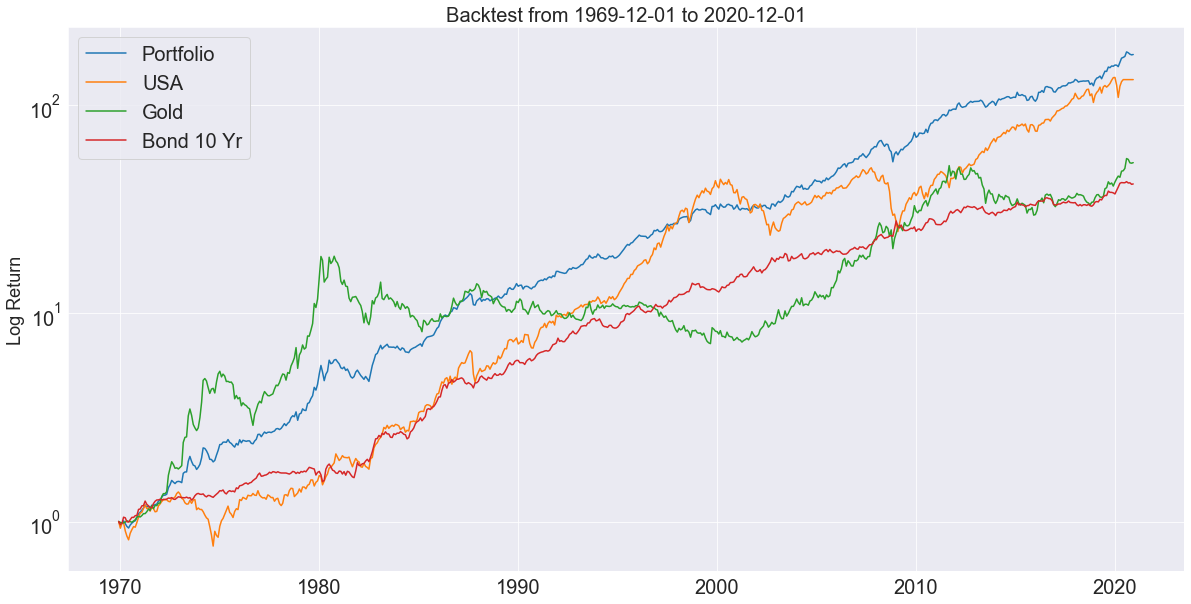

In [379]:
plot(res, "log") # "log" for log otherwise "" for lin

In [376]:
correlation_map(res)

,Portfolio,USA,Gold,Bond 10 Yr
Portfolio,1.00,0.53,0.75,0.40
USA,0.53,1.00,-0.06,0.12
Gold,0.75,-0.06,1.00,0.05
Bond 10 Yr,0.40,0.12,0.05,1.00


# Optimazation

In [350]:
result = Optimize_Portfolio(data, objective='Sharpe')

In [351]:
result['x'].round(2)

array([0.18, 0.09, 0.73])

In [352]:
risk_parity(data)

[0.25, 0.23, 0.52]